In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Pacific_Extent = pd.read_excel(filepath, sheet_name='Pacific-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Pacific_Extent)
fp.date_time(Pacific_Extent)

,Extent,Date
0,668714.275,1979-01-01
1,566930.458,1979-02-01
2,688420.115,1979-03-01
3,859963.043,1979-04-01
4,1127120.160,1979-05-01
...,...,...
533,1134056.102,2023-06-01
534,1484824.377,2023-07-01
535,1671324.717,2023-08-01
536,1726376.097,2023-09-01


In [5]:
scaler = MinMaxScaler()
Pacific_Extent['Extent'] = scaler.fit_transform(Pacific_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 7
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Pacific_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((520, 12, 1), (520,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Pacific_model_LT7/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 17s 205ms/step - loss: 0.2442 - root_mean_squared_error: 0.4942 - val_loss: 0.2264 - val_root_mean_squared_error: 0.4758
Epoch 2/50
53/53 [==============================] - 10s 189ms/step - loss: 0.1417 - root_mean_squared_error: 0.3764 - val_loss: 0.0692 - val_root_mean_squared_error: 0.2630
Epoch 3/50
53/53 [==============================] - 10s 183ms/step - loss: 0.0668 - root_mean_squared_error: 0.2584 - val_loss: 0.0628 - val_root_mean_squared_error: 0.2505
Epoch 4/50
53/53 [==============================] - 10s 192ms/step - loss: 0.0611 - root_mean_squared_error: 0.2471 - val_loss: 0.0558 - val_root_mean_squared_error: 0.2363
Epoch 5/50
53/53 [==============================] - 10s 190ms/step - loss: 0.0532 - root_mean_squared_error: 0.2306 - val_loss: 0.0463 - val_root_mean_squared_error: 0.2151
Epoch 6/50
53/53 [==============================] - 10s 185ms/step - loss: 0.0437 - root_mean_squared_error: 0.2090 - val_loss: 0.0380 

Epoch 32/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0094 - root_mean_squared_error: 0.0970 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0803
Epoch 33/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0088 - root_mean_squared_error: 0.0939 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0788
Epoch 34/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0089 - root_mean_squared_error: 0.0945 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0857
Epoch 35/50
53/53 [==============================] - 10s 187ms/step - loss: 0.0087 - root_mean_squared_error: 0.0932 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0778
Epoch 36/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0081 - root_mean_squared_error: 0.0900 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0779
Epoch 37/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0090 - root_mean_squared_error: 0.0946 - val_loss: 0.0065 - va

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

4.784436329205831 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

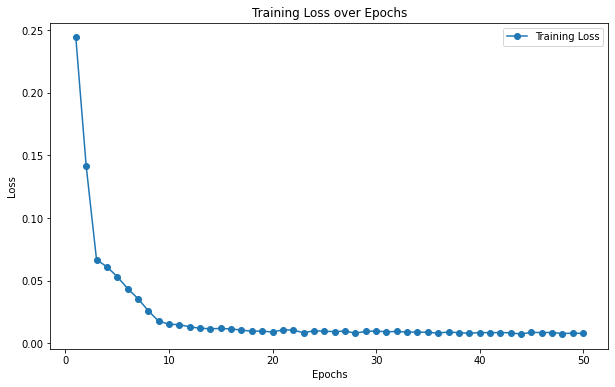

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

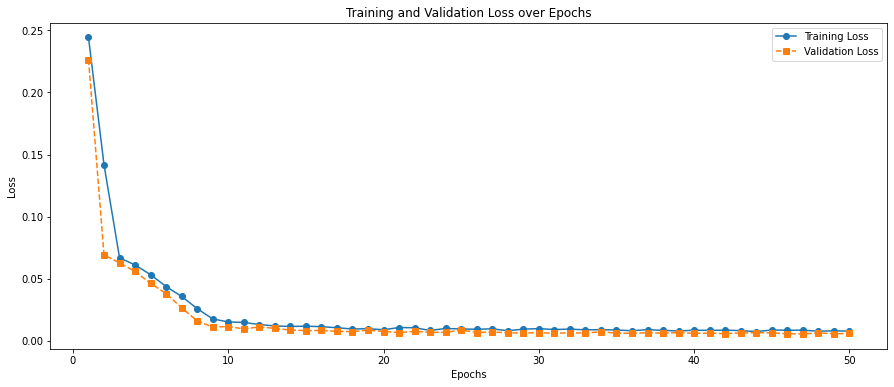

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Pacific_model_LT7/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 22ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.05727811208473673
MAE : 0.044215543297535326


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,1.365449e+06,1264318.504
1,9.498230e+05,863206.294
2,6.285050e+05,635624.004
3,4.610828e+05,460009.672
4,5.028306e+05,610848.036
5,8.123802e+05,819257.445
6,1.195586e+06,1129627.707
7,1.465665e+06,1463383.236
8,1.676659e+06,1614536.727
9,1.815616e+06,1862498.612


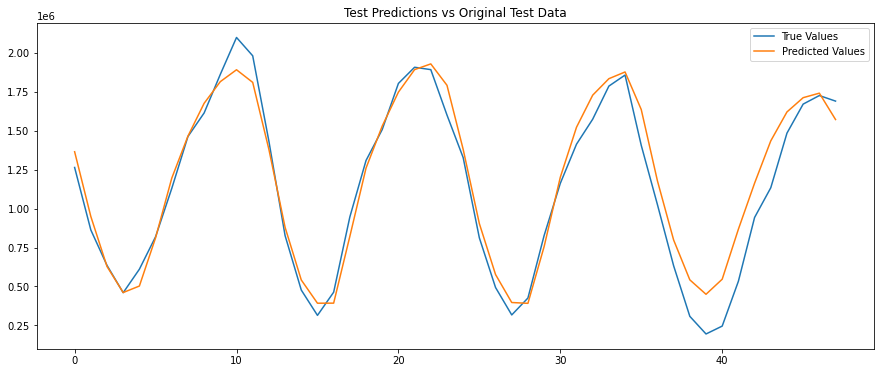

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 16ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

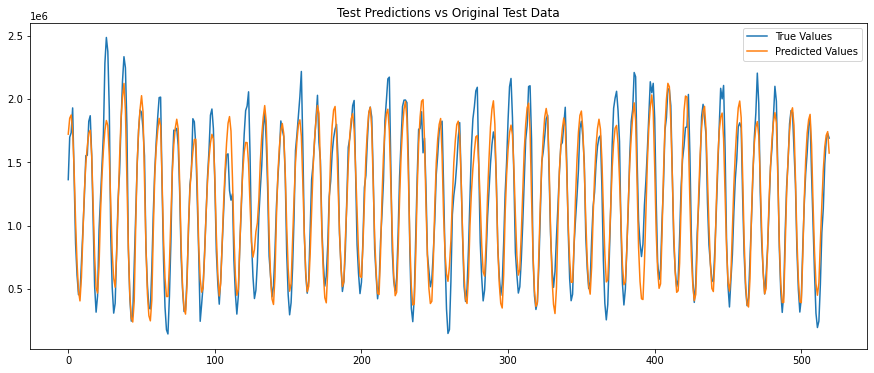

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()